<a href="https://colab.research.google.com/github/prashanth018/Text-Summarization/blob/shreya/Text_Summarization_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import io 
import spacy
from time import time
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving news_summary.csv to news_summary.csv


In [ ]:
uploaded1 = files.upload()

Saving news_summary_more.csv to news_summary_more (1).csv


In [ ]:
data1 = pd.read_csv('news_summary.csv',encoding="latin-1")
data2 = pd.read_csv(io.BytesIO(uploaded1[r'news_summary_more.csv']))
pre1 = data2.iloc[:,0:2].copy()
pre2 = data1.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']],
                           ignore_index=True)
pre.head(2)

In [ ]:
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [ ]:
processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])
processed_text

<generator object text_strip at 0x7f881bf525d0>

In [ ]:
nlp = spacy.load('en', disable=['ner', 'parser']) 
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5000)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

In [ ]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [ ]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [ ]:
pre['cleaned text'] = pd.Series(text)
pre['cleaned summary'] = pd.Series(summary)
pre

,text,summary,cleaned text,cleaned summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim...",speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...
...,...,...,...,...
102910,"Mansha Mahajan 24 Feb 2017,Friday http://india...",Rasna seeking ?250 cr revenue from snack categ...,mansha mahajan 24 feb 2017 friday indiatoday.i...,_START_ rasna seeking 250 cr revenue from snac...
102911,"Dishant Sharma 03 Aug 2017,Thursday http://ind...",Sachin attends Rajya Sabha after questions on ...,dishant sharma 03 aug 2017 thursday indiatoday...,_START_ sachin attends rajya sabha after quest...
102912,"Tanya Dhingra 03 Aug 2017,Thursday http://www....",Shouldn't rob their childhood: Aamir on kids r...,tanya dhingra 03 aug 2017 thursday www.hindust...,_START_ shouldn rob their childhood aamir on k...
102913,"Pragya Swastik 07 Dec 2016,Wednesday http://in...","Asha Bhosle gets ?53,000 power bill for unused...",pragya swastik 07 dec 2016 wednesday indiatoda...,_START_ asha bhosle gets 53 000 power bill for...


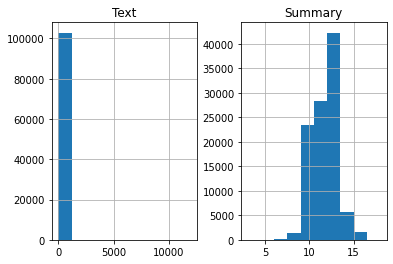

In [ ]:
text_count = []
summary_count = []
for sent in pre['cleaned text']:
  text_count.append(len(sent.split()))
for sent in pre['cleaned summary']:
  summary_count.append(len(sent.split()))
graph = pd.DataFrame()
graph['Text'] = text_count
graph['Summary'] = summary_count
graph.hist(bins=10)
plt.show()

In [ ]:
cnt = 0
for sent in pre['cleaned text']:
  if len(sent.split())<=100:
    cnt=cnt+1
print(cnt/len(pre['cleaned text']))

0.9578389933440218


In [ ]:
max_text_len = 100
max_summary_len = 15

In [ ]:
short_text = []
short_summary = []
cleaned_text = np.array(pre['cleaned text'])
cleaned_summary = np.array(pre['cleaned summary'])
for i in range(len(cleaned_text)):
  if len(cleaned_text[i].split())<=max_text_len and len(cleaned_summary[i].split())<=max_summary_len:
    short_text.append(cleaned_text[i])
    short_summary.append(cleaned_summary[i])
post_pre = pd.DataFrame({'Text':short_text,'Summary':short_summary})
post_pre

,Text,Summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...
...,...,...
98343,tarun khanna 03 mar 2017 friday indiatoday.int...,_START_ cop mocked by shobhaa de undergoes sur...
98344,nan,_START_ need regulatory body for medical devic...
98345,nan,_START_ india got only 17 drs referrals right ...
98346,nan,_START_ business models of e-tailers have not ...


In [ ]:
post_pre['Summary'] = post_pre['Summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')
post_pre

,Text,Summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...
2,new zealand defeated india by wickets in the f...,sostok _START_ new zealand end rohit sharma-le...
3,with aegon life iterm insurance plan customers...,sostok _START_ aegon life iterm insurance plan...
4,speaking about the sexual harassment allegatio...,sostok _START_ have known hirani for yrs what ...
...,...,...
98343,tarun khanna 03 mar 2017 friday indiatoday.int...,sostok _START_ cop mocked by shobhaa de underg...
98344,nan,sostok _START_ need regulatory body for medica...
98345,nan,sostok _START_ india got only 17 drs referrals...
98346,nan,sostok _START_ business models of e-tailers ha...


In [ ]:
x_tr,x_val,y_tr,y_val = train_test_split(np.array(post_pre['Text']),np.array(post_pre['Summary']),
                                         test_size=0.1,random_state=0,shuffle=True)

In [ ]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh = 5
cnt = 0
total_cnt = 0
for key,value in x_tokenizer.word_counts.items():
  total_cnt = total_cnt+1
  if value < thresh:
    cnt =cnt+1
print("% of rare words in the Vocabulary:",(cnt/total_cnt)*100)

% of rare words in the Vocabulary: 62.61133960788272


In [ ]:
x_tokenizer = Tokenizer(num_words = total_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_voc = x_tokenizer.num_words + 1
print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 29636


In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh = 5
cnt = 0
total_cnt = 0
for key,value in y_tokenizer.word_counts.items():
  total_cnt = total_cnt+1
  if value < thresh:
    cnt = cnt+1
print("% of rare words in the vocabulary:",(cnt/total_cnt)*100)

% of rare words in the vocabulary: 62.55232558139535


In [ ]:
y_tokenizer = Tokenizer(num_words=total_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)
y_tr = pad_sequences(y_tr_seq,maxlen=max_summary_len,padding='post')
y_val = pad_sequences(y_val_seq,maxlen=max_summary_len,padding='post')
y_voc = y_tokenizer.num_words + 1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 12883


array([[   3,    2,   36, ...,    0,    0,    0],
       [   3,    2, 4033, ...,    4,    0,    0],
       [   3,    2, 7665, ...,    1,    4,    0],
       ...,
       [   3,    2,   35, ...,    4,    0,    0],
       [   3,    2, 1964, ...,    4,    0,    0],
       [   3,    2, 3407, ...,    4,    0,    0]], dtype=int32)

In [ ]:
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [ ]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [ ]:
latent_dim = 300
embedding_dim = 200
encoder_input = Input(shape=(max_text_len,))
emb_layer = Embedding(x_voc,embedding_dim,trainable=True)(encoder_input)
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output1,state_h1,state_c1) = encoder_lstm1(emb_layer)
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True, dropout=0.4,recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(latent_dim, return_state=True,return_sequences=True, dropout=0.4,recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)
decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True,return_state=True, dropout=0.4,recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_input, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 200)     5927200     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 100, 300), ( 601200      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
692/692 [==============================] - 6554s 9s/step - loss: 5.5946 - val_loss: 4.8562
Epoch 2/50
166/692 [======>.......................] - ETA: 1:18:59 - loss: 4.9047

KeyboardInterrupt: ignored